###  Example of stimulus encoding by the coherence using AR signals

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import time
import h5py

import scipy
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import numba                 as     nb

from   tqdm                  import tqdm

import GDa.graphics.plot     as     plot
import matplotlib.pyplot     as     plt
import matplotlib

from frites.simulations     import StimSpecAR
from xfrites.conn.conn_spec import conn_spec

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [3]:
# Create directory to save figures
if not os.path.exists("img/n6.5"):
    os.makedirs("img/n6.5")

### Simulate two AR models

In [4]:
def ar_model_dhamala(n=5000, sfreq = 200, C = 0.2, stim = None, t_onset=0, t_offset=None, cov = None):
    r"""
    Simulate the vector auto-regressive model from Dhamala et. al. (2008)

    $X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

    $X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

    Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
    such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
    $X_2(t)$ influences $X_1(t)$ through the coupling constant $C$

    Parameters
    ----------

    n: int | 5000
        Number of samples
    sfreq: float | 200
        Sampling frequency
    C: float, array_like | 0.2
        Couling between the two variables
    stim: array_like | None
        The array with the stimulus
    t_onset: float, array_like | 0
        Stimulus onset for each trial
    t_offset: float, array_like | None
        stimulus offset for each trial
    cov: array_like | None
        Covariance matrix of the white noise.

    Returns
    -------
    Z: array_like
        The time-series for the simulated system (n_epochs, n_roi, n_times)
        
    """
    
    #______________________________________ Input checking ______________________________________#
    assert isinstance(n, int)
    assert isinstance(sfreq, int)
    assert isinstance(cov, np.ndarray) and cov.ndim == 2
    
    # Simulation time
    T = n / sfreq
    
    # Number of trials, if no stim is provided simulate one trial
    if isinstance(stim, (list,tuple,np.ndarray)):
        # Number of trials
        trials = len(stim)
        # Checking coupling and onset offset of stimulus
        if   isinstance(C, float): C = np.array([C]*trials)
        elif isinstance(C, (list,tuple,np.ndarray)): assert len(C)==len(stim)
        if   isinstance(t_onset, float): t_onset = np.array([t_onset]*trials)
        elif isinstance(t_onset, (list,tuple,np.ndarray)): assert len(t_onset)==len(stim)
        if   isinstance(t_offset, float): t_offset = np.array([t_offset]*trials)
        elif isinstance(t_offset, (list,tuple,np.ndarray)): assert len(t_offset)==len(stim)
    else:
        trials = 1
        assert isinstance(C, float)
        assert isinstance(t_onset, float)
        assert isinstance(t_offset, float)
        
    #______________________________________ Simulation ______________________________________#

    # Time array
    time = np.linspace(0, T, n)

    X = np.random.random([trials, n]) 
    Y = np.random.random([trials, n]) 

    def interval(t, t_onset, t_offset):
        if t_offset==None:
            return (t>=t_onset)
        else:
            return (t>=t_onset)*(t<=t_offset)

    for i in tqdm( range(trials) ):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(n,))
        for t in range(2, n): 
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_onset[i],t_offset[i])*C[i]*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] + E[t,1]

    Z = np.zeros([trials,2,n]) 

    Z[:,0,:] = X 
    Z[:,1,:] = Y 
    
    Z = xr.DataArray(Z, dims=('trials', 'roi', 'times'),
                 coords=(stim, ['X1', 'X2'], time))

    return Z

In [5]:
# Number of observations
n     = 5000      
# Sampling frequency
sfreq = 200    
# Time resolution
dt = 1.0 / sfreq 
# Coupling parameter
C  = 0.25      
# Frequency axis
freqs  = np.arange(1,100,1) 
# Covariance matrix
cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])

# Number of trials 
n_trials = 100
# Number of stimulus
n_stim   = 5
# Stimulus array
stim     = np.random.randint(0, n_stim,n_trials)
# Coupling for each trials


# Stimulus onset for each trial
x       = np.arange(1, 25, 5)
t_start = np.random.uniform(0, np.repeat(x,n_trials//len(x)))
# Stimulus offset for each trial
t_stop  = t_start + 2 #np.random.uniform(2, 5, n_trials)

In [6]:
# Simulate one signal where the coupling is stimulus dependent and one where it is independent
X = []
for i in range(2):
    if i==0: coup = stim/10*2 + np.random.uniform(0, 0.1)
    else:    coup = 0.2
    X += [ar_model_dhamala(n=n,sfreq=sfreq,C=coup,stim=stim,t_onset=t_start,t_offset=t_stop,cov=cov)]

100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


### Compute time-resolved coherence

In [7]:
freqs  = np.arange(1,100,1) # Frequency axis

In [8]:
# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times="times", roi="roi", foi=None, n_jobs=20,
    mode='morlet', n_cycles=n_cycles, decim=15, metric="coh", 
    sm_times=.3, sm_freqs=1, sm_kernel="square", block_size=1
)

coh = []
for i in range(2): coh += [conn_spec(X[i], **kw).isel(times=slice(20,-20))]

Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=4, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=4, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

### MI workflow

In [8]:
from frites.dataset  import SubjectEphy, DatasetEphy
from frites.workflow import WfMi

In [10]:
mi, pv = [], []

for i in range(2):
    dt = DatasetEphy([coh[i]], y="trials", times="times", roi="roi", agg_ch=False)

    mi_type   = 'cd'
    inference = 'ffx'
    kernel    = np.hanning(3)
    wf        = WfMi(mi_type, inference, verbose=True, kernel=kernel)

    # list of corrections for multiple comparison
    mcps = ['cluster', 'maxstat', 'fdr', 'bonferroni']
    kw = dict(n_jobs=20, n_perm=100)
    """
    The `cluster_th` input parameter specifies how the threshold is defined.
    Use either :
    * a float for a manual threshold
    * None and it will be infered using the distribution of permutations
    * 'tfce' for a TFCE threshold
    """
    cluster_th = 'tfce'  # {float, None, 'tfce'}

    out_1, out_2 = wf.fit(dt, mcp="cluster", cluster_th=cluster_th, **kw)
    
    mi += [out_1]
    pv += [out_2]

Definition of an electrophysiological dataset
    Dataset composed of 1 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cd)
    Evaluate true and permuted mi (n_perm=100, n_jobs=20)


  0%|          | Estimating MI : 0/1 [00:00<?,       ?it/s]

    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=True)
    Inference at cluster-level
    Cluster detection (threshold={'start': 0.048048986980335766, 'step': 0.001535551004754058, 'e_power': 0.5, 'h_power': 2}; tail=1)
Definition of an electrophysiological dataset
    Dataset composed of 1 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cd)
    Evaluate true and permuted mi (n_perm=100, n_jobs=20)


  0%|          | Estimating MI : 0/1 [00:00<?,       ?it/s]

    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=True)
    Inference at cluster-level
    Cluster detection (threshold={'start': 0.04815147927138345, 'step': 0.0011798013668571229, 'e_power': 0.5, 'h_power': 2}; tail=1)


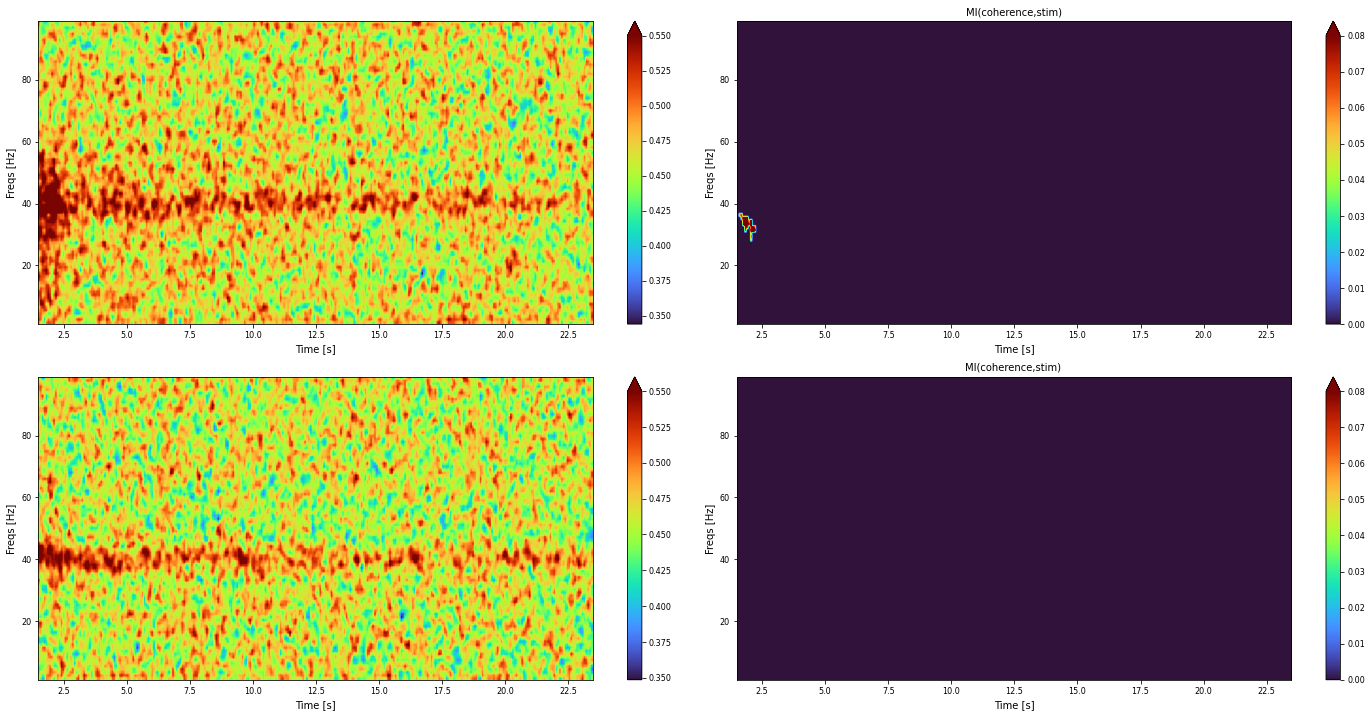

In [11]:
plt.figure(figsize=(20,10))
extent = [mi[0].times[0], mi[0].times[-1], mi[0].freqs[0], mi[0].freqs[-1]]
plt.subplot(2,2,1)
plt.imshow(coh[0].mean("trials").squeeze(), aspect="auto", cmap="turbo", origin="lower", extent=extent, vmax=.55)
plt.colorbar(extend="max")
plt.ylabel("Freqs [Hz]", fontsize=MEDIUM_SIZE)
plt.xlabel("Time [s]", fontsize=MEDIUM_SIZE)
plt.subplot(2,2,3)
plt.imshow(coh[1].mean("trials").squeeze(), aspect="auto", cmap="turbo", origin="lower", extent=extent, vmax=.55)
plt.colorbar(extend="max")
plt.ylabel("Freqs [Hz]", fontsize=MEDIUM_SIZE)
plt.xlabel("Time [s]", fontsize=MEDIUM_SIZE)

plt.subplot(2,2,2)
plt.imshow((mi[0]*(pv[0]<0.05)).squeeze(), aspect="auto", cmap="turbo", origin="lower", extent=extent, vmax=.08)
plt.title(r"MI(coherence,stim)", fontsize=MEDIUM_SIZE)
plt.colorbar(extend="max")
plt.ylabel("Freqs [Hz]", fontsize=MEDIUM_SIZE)
plt.xlabel("Time [s]", fontsize=MEDIUM_SIZE)

plt.subplot(2,2,4)
plt.imshow((mi[1]*(pv[1]<0.05)).squeeze(), aspect="auto", cmap="turbo", origin="lower", extent=extent, vmax=.08)
plt.title("MI(coherence,stim) ", fontsize=MEDIUM_SIZE)
plt.colorbar(extend="max")
plt.ylabel("Freqs [Hz]", fontsize=MEDIUM_SIZE)
plt.xlabel("Time [s]", fontsize=MEDIUM_SIZE)

plt.tight_layout()

In [9]:
from mne.connectivity import spectral_connectivity

In [13]:
conn_m, cfreqs, _, _, _ = spectral_connectivity(
    X[0].values, sfreq=sfreq, cwt_freqs=freqs, cwt_n_cycles=n_cycles,
    mode='cwt_morlet', verbose=False,
    indices=(np.array([0]), np.array([1])), n_jobs=40)

Text(0.5, 1.0, 'XFRITES')

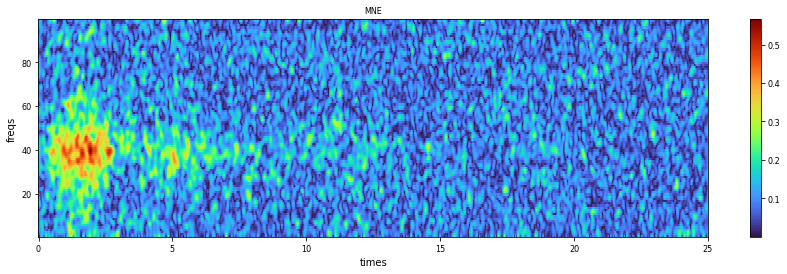

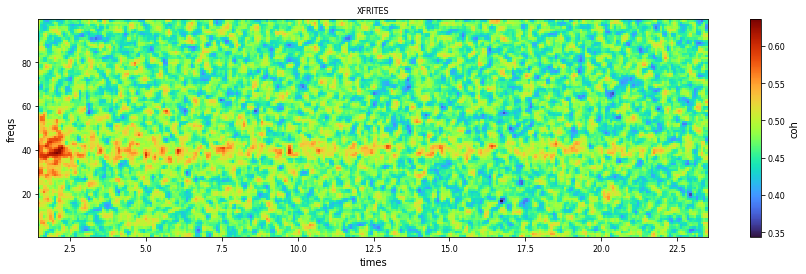

In [14]:
plt.figure(figsize=(15,4))
conn_m = xr.DataArray(conn_m.squeeze(), dims=('freqs', 'times'),
                      coords=(cfreqs, X[0].times.values))
conn_m.plot(x='times', y='freqs', cmap='turbo')
plt.title("MNE")
plt.figure(figsize=(15,4))
coh[0].isel(roi=0).mean("trials").plot(x='times', y='freqs', cmap='turbo')
plt.title("XFRITES")

In [15]:
m_coh = []
for t_o, t_f in zip(t_start, t_stop):
    m_coh += [coh[0].sel(freqs=slice(30,50), times=slice(t_o,t_f)).mean() ]

In [16]:
m_coh_mne = []
for t_o, t_f in zip(t_start, t_stop):
    m_coh_mne += [conn_m.sel(freqs=slice(30,50), times=slice(t_o,t_f)).mean()]

Text(0.5, 0, 'onset')

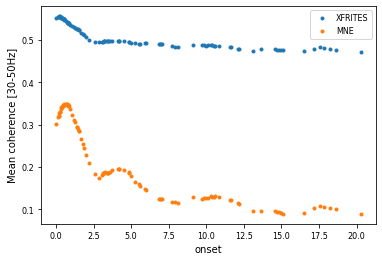

In [17]:
plt.plot(t_start, m_coh, ".")
plt.plot(t_start, m_coh_mne, ".")
plt.legend(["XFRITES","MNE"])
plt.ylabel("Mean coherence [30-50Hz]")
plt.xlabel("onset")

In [18]:
coh[0].sel(freqs=slice(30, 50)).mean() / coh[0].sel(freqs=slice(5, 25)).mean()

<xarray.DataArray 'coh' ()>
array(1.03745309)

In [14]:
x = np.arange(0, 25, 5)
mne_ratio, xfrite_ratio = [], []
for _x in x:
    
    t_start = np.random.uniform(0, _x, (n_trials,))
    t_stop  = t_start + 2 

    X = ar_model_dhamala(n=n,sfreq=sfreq,C=coup,stim=stim,t_onset=t_start,t_offset=t_stop,cov=cov)
    
    n_cycles = 7
    
    # coherence with mne
    coh_mne, cfreqs, _, _, _ = spectral_connectivity(
                                X.values, sfreq=sfreq, cwt_freqs=freqs, cwt_n_cycles=n_cycles,
                                mode='cwt_morlet', verbose=False,
                                indices=(np.array([0]), np.array([1])), n_jobs=40)
    
    coh_mne = xr.DataArray(coh_mne.squeeze(), dims=('freqs', 'times'),
                      coords=(cfreqs, X[0].times.values))
    
    mne_ratio += [coh_mne.sel(freqs=slice(30, 50)).mean() / coh_mne.sel(freqs=slice(5, 25)).mean()]
    
    # coherence with xfrites
    kw = dict(
        freqs=freqs, times="times", roi="roi", foi=None, n_jobs=-1,
        mode='morlet', n_cycles=n_cycles, decim=15, metric="coh", 
        sm_times=1, sm_freqs=1, sm_kernel="gaussian", block_size=1
    )

    coh_frites = conn_spec(X, **kw)
    xfrite_ratio += [coh_frites.sel(freqs=slice(30, 50)).mean() / coh_frites.sel(freqs=slice(5, 25)).mean()]

100%|██████████| 100/100 [00:03<00:00, 30.51it/s]
For Gaussian kernel the the temporal width of the kernel is estimated based on freqs, sfreq and n_cycles... sm_times not used. 
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=13, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

100%|██████████| 100/100 [00:03<00:00, 30.45it/s]
For Gaussian kernel the the temporal width of the kernel is estimated based on freqs, sfreq and n_cycles... sm_times not used. 
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=13, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

100%|██████████| 100/100 [00:03<00:00, 31.04it/s]
For Gaussian kernel the the temporal width of the kernel is estimated based on freqs, sfreq and n_cycles... sm_times not used. 
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=13, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

100%|██████████| 100/100 [00:03<00:00, 30.91it/s]
For Gaussian kernel the the temporal width of the kernel is estimated based on freqs, sfreq and n_cycles... sm_times not used. 
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=13, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

100%|██████████| 100/100 [00:03<00:00, 30.73it/s]
For Gaussian kernel the the temporal width of the kernel is estimated based on freqs, sfreq and n_cycles... sm_times not used. 
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=13, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

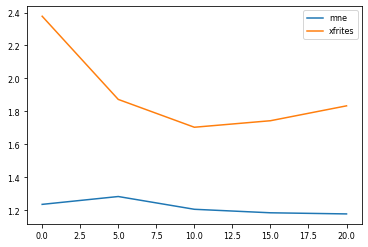

In [18]:
plt.plot(x, mne_ratio)
plt.plot(x, xfrite_ratio)
plt.legend(["mne","xfrites"])

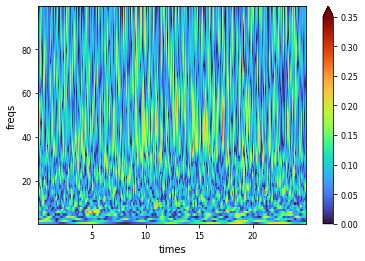

In [19]:
coh_mne.isel(times=slice(5,-5)).plot(x="times", y="freqs", cmap="turbo", vmin=0.0, vmax=.35)

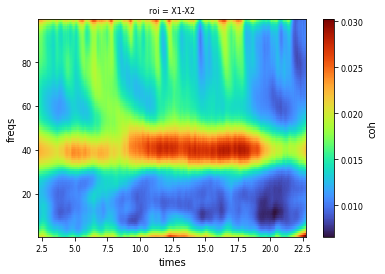

In [20]:
coh_frites.mean("trials").isel(times=slice(30,-30)).plot(x="times", y="freqs", cmap="turbo")